# Wire Image Data

## Purpose of this notebook

This notebook provides an example for visualizing the recorded data in each event as a set of images, one per TPC plane. The image can be used for visual data processing, such as convolutional neural networks. Recent examples from MicroBooNE are “Semantic Segmentation with a Sparse Convolutional Neural Network for Event Reconstruction in MicroBooNE”, arXiv:2012.08513, Phys. Rev. D103, 052012 (2021) and ”A Convolutional Neural Network for Multiple Particle Identification in the MicroBooNE Liquid Argon Time Projection Chamber”, arXiv:2010.08653, Phys. Rev. D103, 092003 (2021). 

In order to use this notebook, samples labeled as "with Wire" need to be used; due to large size of the Wire waveform information, these are samples with reduced number of events. The 2D image shows the time (in TPC clock ticks) vs the wire number, and the color scale is the wire waveform amplitude at each tick in ADC units. Larger ADC values mean larger deposited charge.

Ground truth information with resolution of image pixels is not provided, as it would further increase the size of the sample. However, as shown in the "Hit Labeling.ipynb" notebook, we provide tools to produce ground truth information from hits that have the same 2D structure of these images and thus can be used to define the image ground truth. For instance, one can check if a non-zero pixel lies on the same wire and within ±`rms` of the `local_time` of a hit, and in that case assign to the pixel the same label as the hit.

## Load useful libraries, utilities, and data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pynuml.io import File
f = File("NeutrinoML_Open_WithWire_50evts.h5")

In [3]:
from detector_utils import *

In [4]:
tables = ['event_table','wire_table']
for t in tables: f.add_group(t)
f.read_data(0, 50)
evts = f.build_evt()

## Extract the Wire information for one event and produce the image

Select the event and print the event_id

In [5]:
evt = evts[46]
evt_id = [evt["event_table"]["run"].iloc[0],evt["event_table"]["subrun"].iloc[0],evt["event_table"]["event"].iloc[0]]
print('Going to produce wire image for event:',evt_id)

Going to produce wire image for event: [7420, 62, 3136]


Extract wire information for this specific event, and get the wire readouts (ADC) for the different planes

In [6]:
wires = evt["wire_table"]

In [7]:
plane0adcs = wires.query("local_plane==0")[['adc_%i'%i for i in range(0,ntimeticks())]].to_numpy()
plane1adcs = wires.query("local_plane==1")[['adc_%i'%i for i in range(0,ntimeticks())]].to_numpy()
plane2adcs = wires.query("local_plane==2")[['adc_%i'%i for i in range(0,ntimeticks())]].to_numpy()

Print information about the number of wires and ACD reads (waveform amplitude at each time tick)

In [8]:
print("number of plane 0 wires=",len(plane0adcs))
print("number of plane 1 wires=",len(plane1adcs))
print("number of plane 2 wires=",len(plane2adcs))
print("number of ADC reads=",len(plane0adcs[0]))
print("plane2 vs plane0/1 aspect ratio = ",len(plane2adcs)/len(plane1adcs))

number of plane 0 wires= 2400
number of plane 1 wires= 2400
number of plane 2 wires= 3456
number of ADC reads= 6400
plane2 vs plane0/1 aspect ratio =  1.44


Let's make the image now for each plane as time tick vs wire number, color-coded based on the ADC value.

Run / Sub / Event : 7420 / 62 / 3136 - saturation set to ADC=15.00


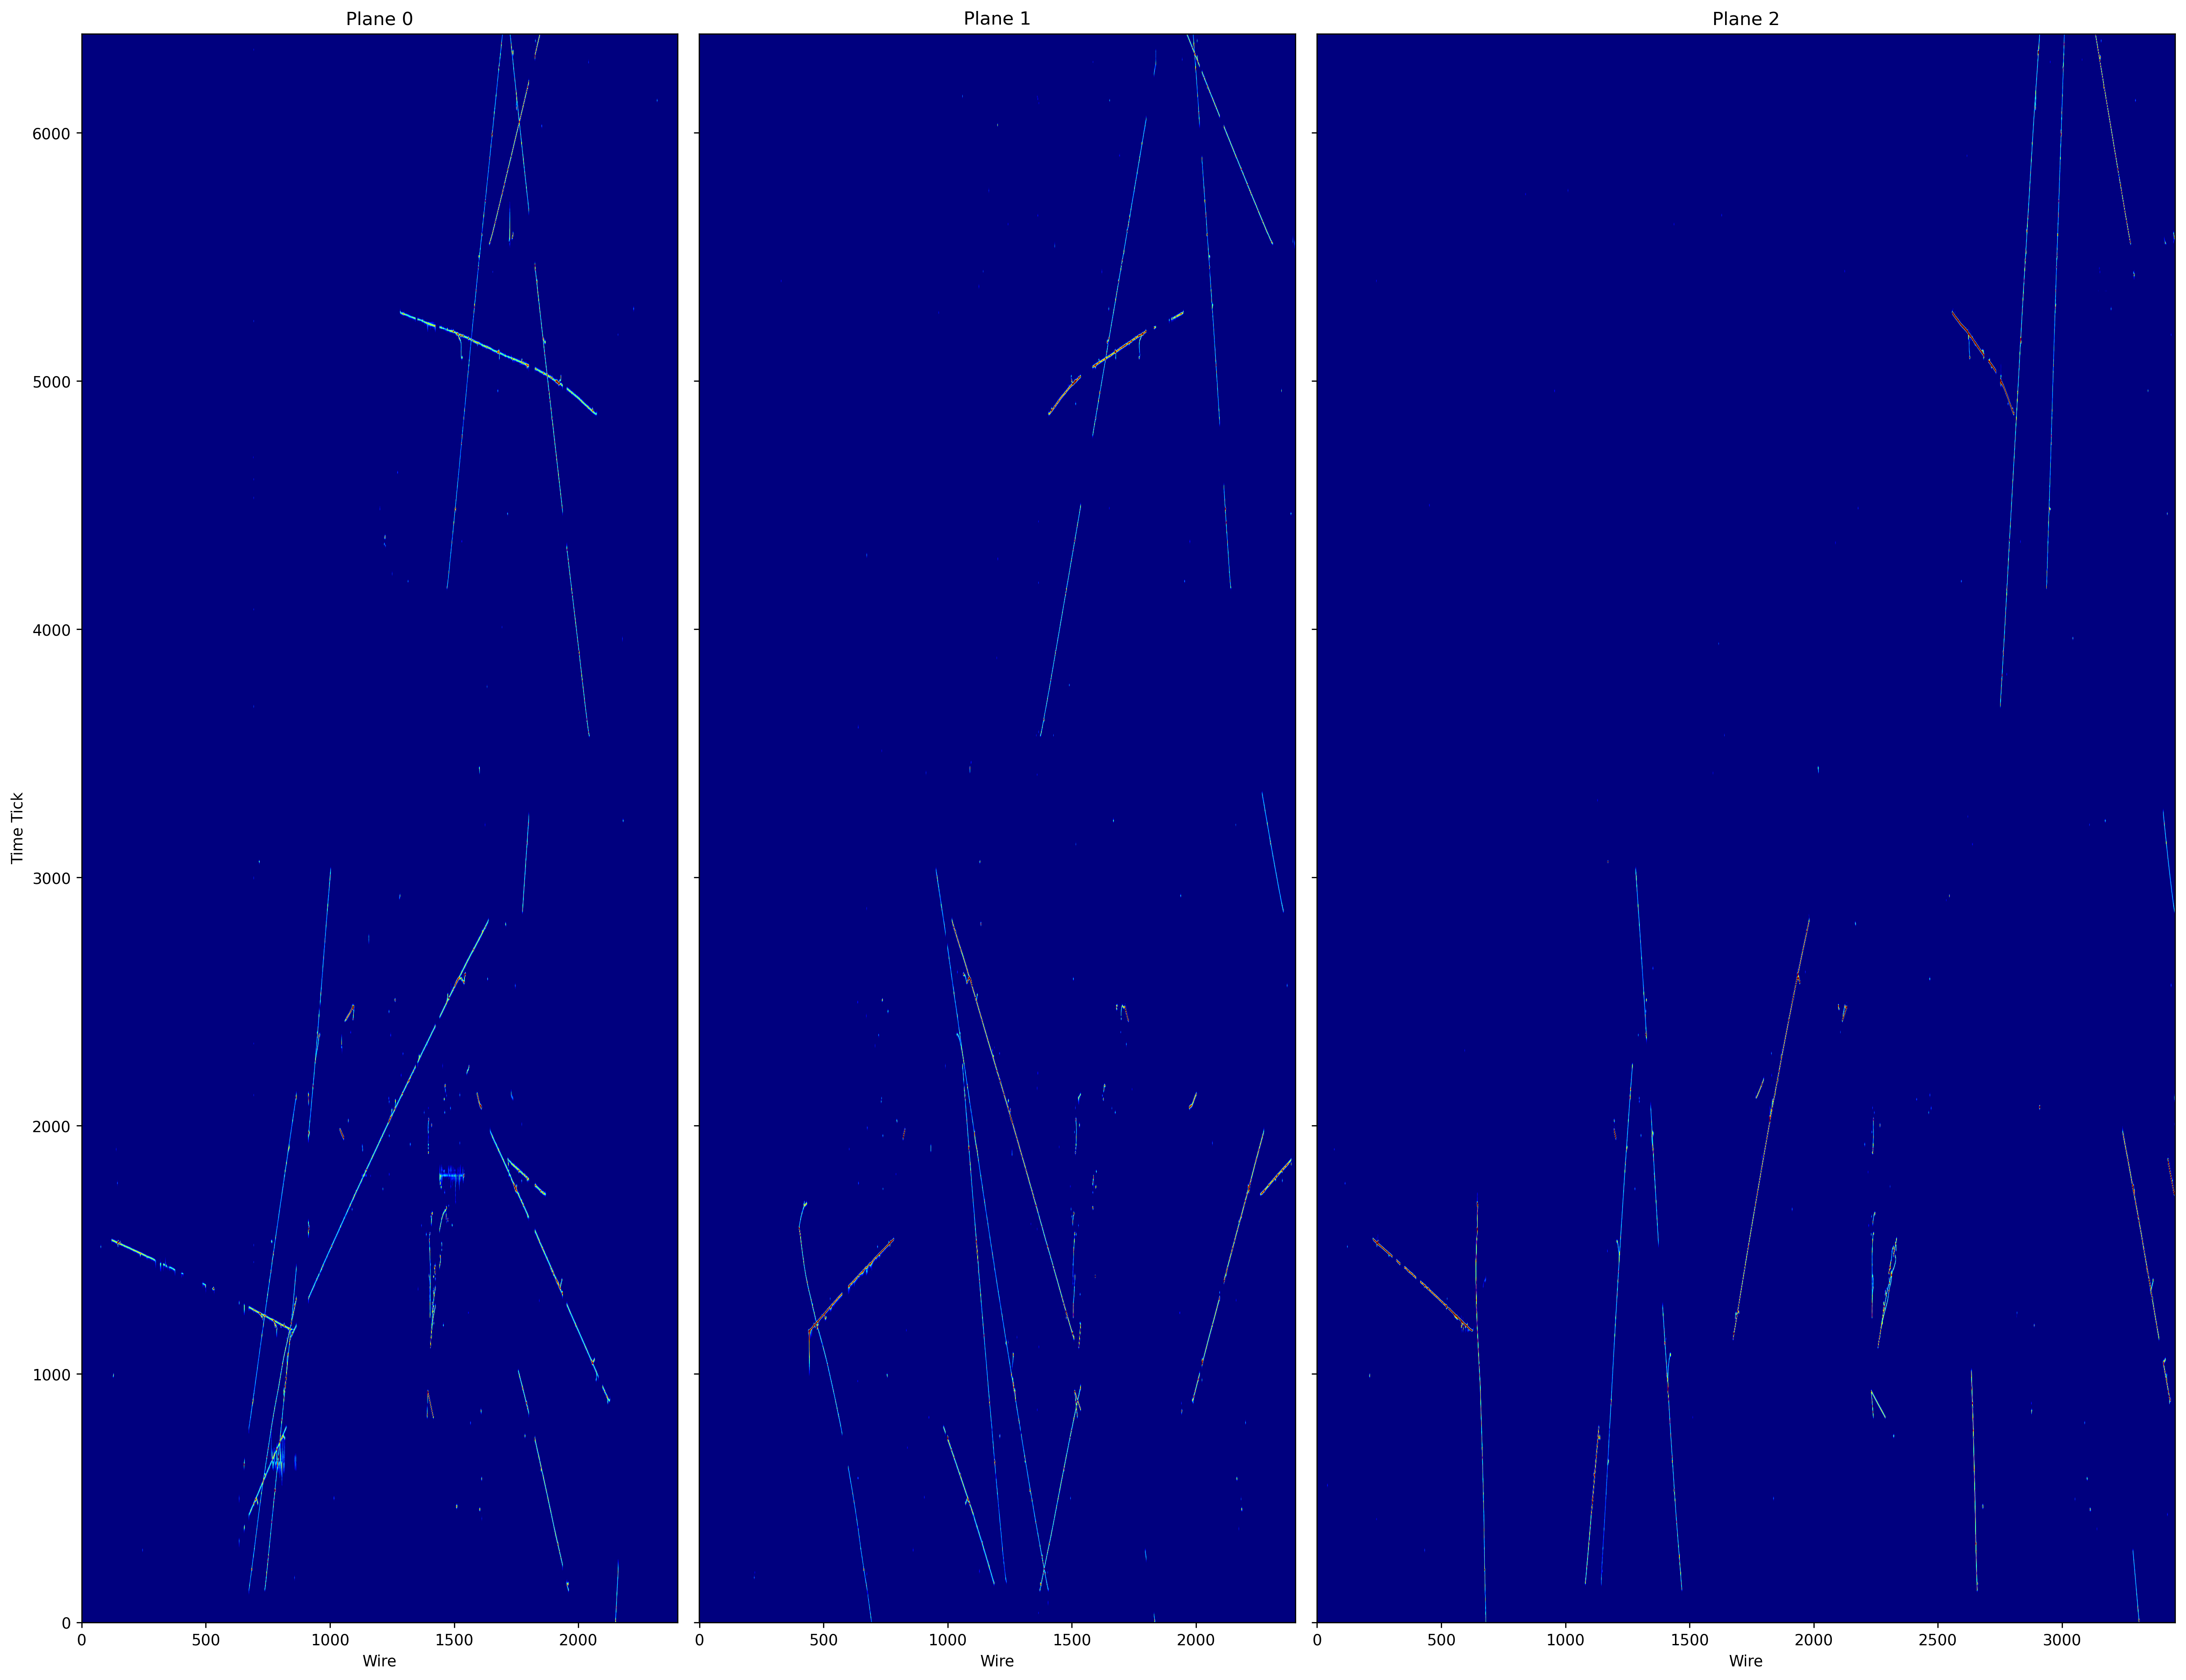

In [9]:
zmax = 15

print("Run / Sub / Event : %i / %i / %i - saturation set to ADC=%.2f"%(evt_id[0],evt_id[1],evt_id[2],zmax))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, \
                                  gridspec_kw={'width_ratios': [1, 1, len(plane2adcs)/len(plane1adcs)]},\
                                  figsize=(20, 15), dpi=250)

im1 = ax1.imshow(plane0adcs.T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax1.set_title("Plane 0")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")

im2 = ax2.imshow(plane1adcs.T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax2.set_title("Plane 1")
ax2.set_xlabel("Wire")

im3 = ax3.imshow(plane2adcs.T,vmin=0,vmax=zmax,origin='lower',cmap='jet')
ax3.set_title("Plane 2")
ax3.set_xlabel("Wire")

plt.tight_layout()